In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go

### Open Data

In [6]:
filepath = '/Users/kunaltamhane/Desktop/CT Scan Segementation/Data/CT_scan.npy'
img = np.load(filepath)

In [7]:
img.shape

(263, 512, 512)

The image is 3D taking Axial Slices

### Plot slice of the image

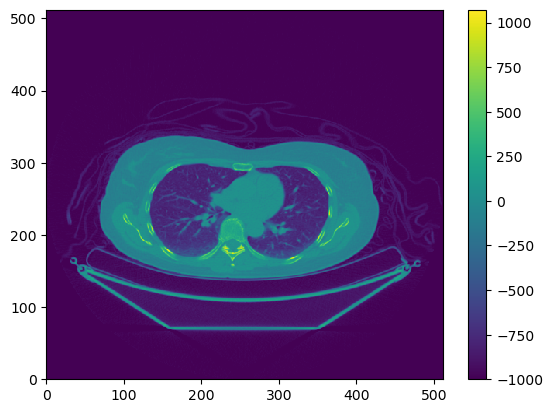

In [8]:
plt.pcolormesh(img[170])
plt.colorbar()

###  Hounsfield unit (HU) is a unit of measurement used in computed tomography (CT) scans to represent radiodensity.

## Modify Data
Air is significantly less HU than other substances in the body so we apply a **threshold mask**. We will use -320 HU as the lower limit:

In [9]:
mask = img < -320

Plot the mask

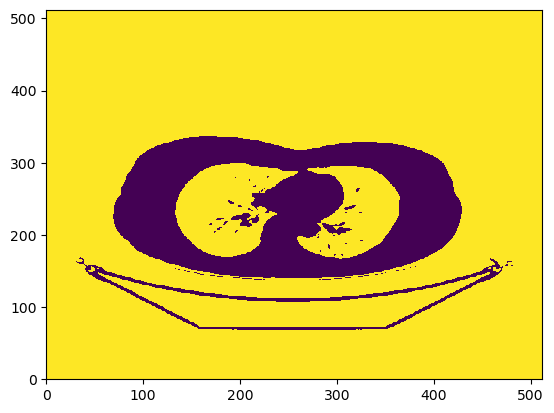

In [10]:
plt.pcolormesh(mask[170])

### Next Step we can use the clear_border function to remove the outer border:

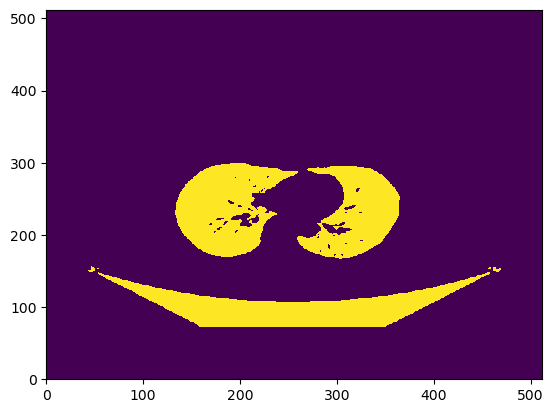

In [13]:
mask = np.vectorize(clear_border, signature = '(n,m)->(n,m)')(mask)
plt.pcolormesh(mask[170])

Now we will give each seperate volume a different integer value using the label function.

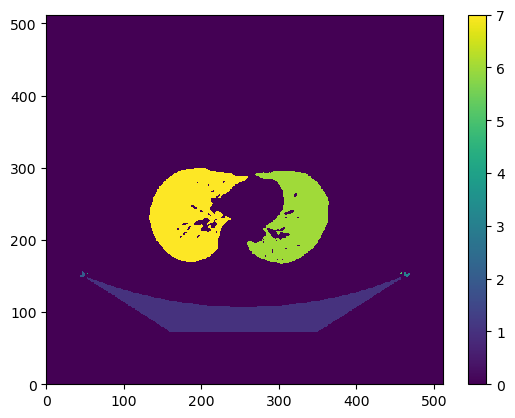

In [15]:
mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask_labeled[170])
plt.colorbar()

Now for something a little non-intuitive. We want to keep the three largest areas for each slice of the image. Why would we want to do this if we only want to keep the two lungs?
- In some slices one of the lungs could be larger than the table 
- In some slices one of the lungs could be smaller than the table

If we only take the largest two slices, we might end up taking the table and one of the lungs. So for now lets take the top 3. The function below is designed to operate on a single slice of the 3D image

In [16]:
slc = mask_labeled[170]
rps = regionprops(slc)
areas = [r.area for r in rps]
idxs = np.argsort(areas)[::-1]

In [18]:
new_slc = np.zeros_like(slc)
for i in idxs[:3]:
    new_slc[tuple(rps[i].coords.T)]=i+1

Only consider 3 largest areas (iterating through idxs). Add these areas to a new slice called new_slc:

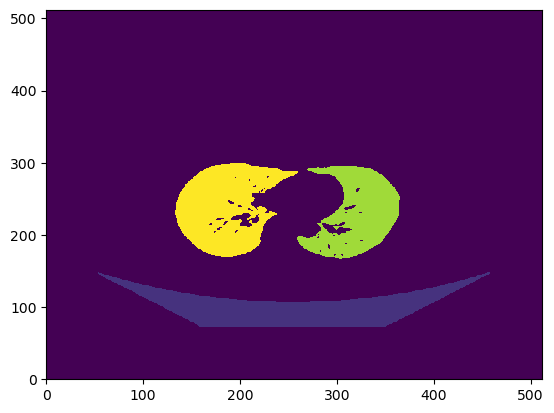

In [19]:
plt.pcolormesh(new_slc)

In [20]:
def keep_top_3(slc):
    new_slc = np.zeros_like(slc)
    rps = regionprops(slc)
    areas = [r.area for r in rps]
    idxs = np.argsort(areas)[::-1]
    for i in idxs[:3]:
        new_slc[tuple(rps[i].coords.T)] = i+1
    return new_slc

In [21]:
mask_labeled = np.vectorize(keep_top_3, signature='(n,m)->(n,m)')(mask_labeled)

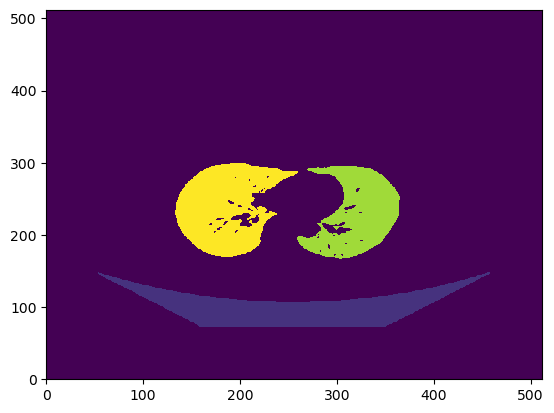

In [22]:
plt.pcolormesh(mask_labeled[170])

Now lets fill in any small holes in the lungs:

In [23]:
mask = mask_labeled > 0
mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)

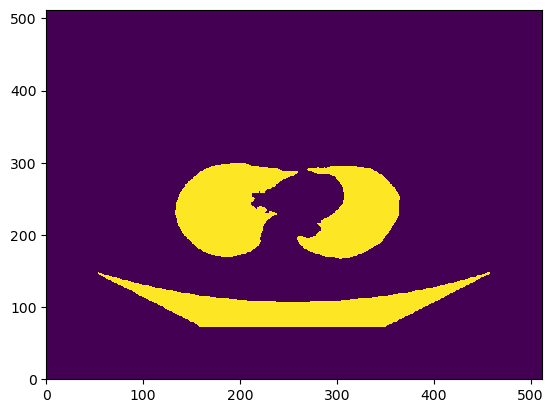

In [24]:
plt.pcolormesh(mask[170])

In some slices, the trachea is kind of annoying and we need to remove it:

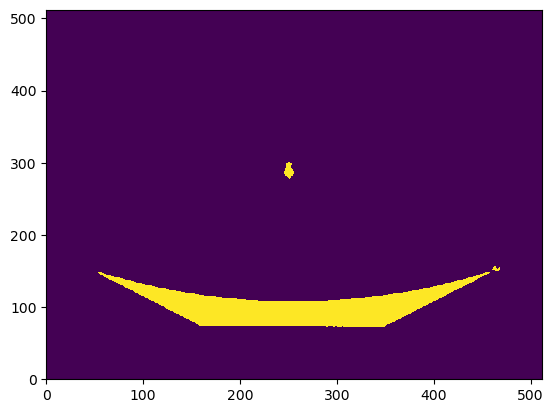

In [25]:
plt.pcolormesh(mask[-50])

In a 512 x 512 image, the trachea typically takes up less than 0.69% of the area. We can delete all regions that have any area smaller than this percentage:

In [26]:
np.where(np.array([1,0,2,3,45,1,2])<2)

(array([0, 1, 5]),)

In [29]:
def remove_trachea(slc, c=0.0069):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1, background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/512**2<c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)]=0
    return new_slc

In [30]:
mask = np.vectorize(remove_trachea, signature='(n,m)->(n,m)')(mask)

Now the trachea is removed in the slice we were considering:

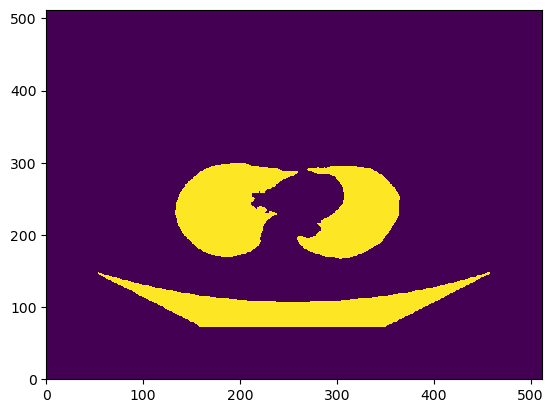

In [32]:
plt.pcolormesh(mask[170])

Finally its time to remove the table. Note that the center of mass of the table is always lower than the two lungs. As such, we simply need to delete the volume with the lowest center of mass in y to delete the table

In [33]:
labels = label(mask, background=0)

Plot a slice of the labels with the masks:

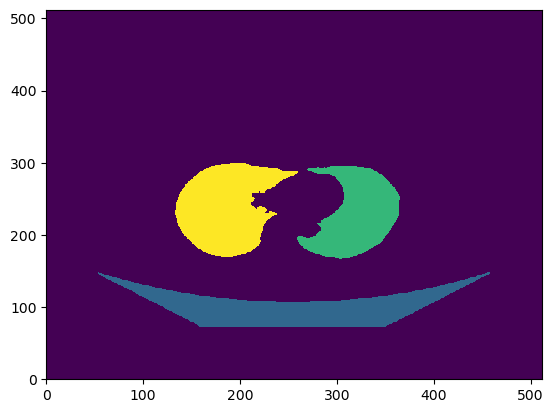

In [34]:
plt.pcolormesh(labels[170])

Compute the center of masses in this slice:

In [35]:
center_of_mass(labels[170]==3)

(237.06954832442935, 185.5185041282176)

In [36]:
def delete_table(slc):
    new_slc = slc.copy()
    labels = label(slc, background=0)
    idxs = np.unique(labels)[1:]
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs])
    for idx, COM_y in zip(idxs, COM_ys):
        if(COM_y < 0.3*slc.shape[0]):
            new_slc[labels==idx]=0
        elif (COM_y > 0.6*slc.shape[0]):
            new_slc[labels==idx]=0
    return new_slc

In [37]:
mask_new = np.vectorize(delete_table, signature='(n,m)->(n,m)')(mask)

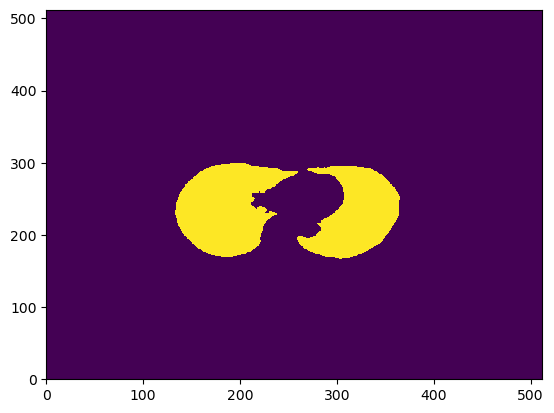

In [38]:
plt.pcolormesh(mask_new[170])

Finally, we can expand the area of the lungs a little bit by growing the border. For this we can use the binary_dilation function

In [39]:
mask = binary_dilation(mask, iterations=5)

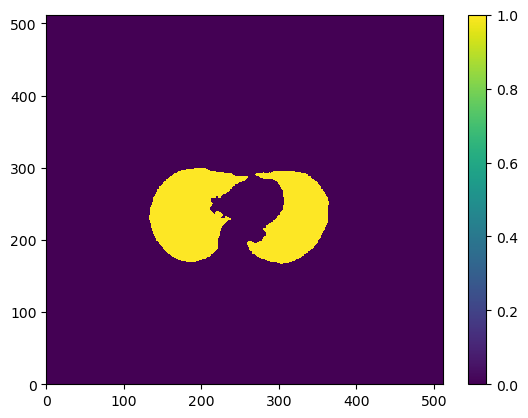

In [41]:
plt.pcolormesh(mask_new[170])
plt.colorbar()

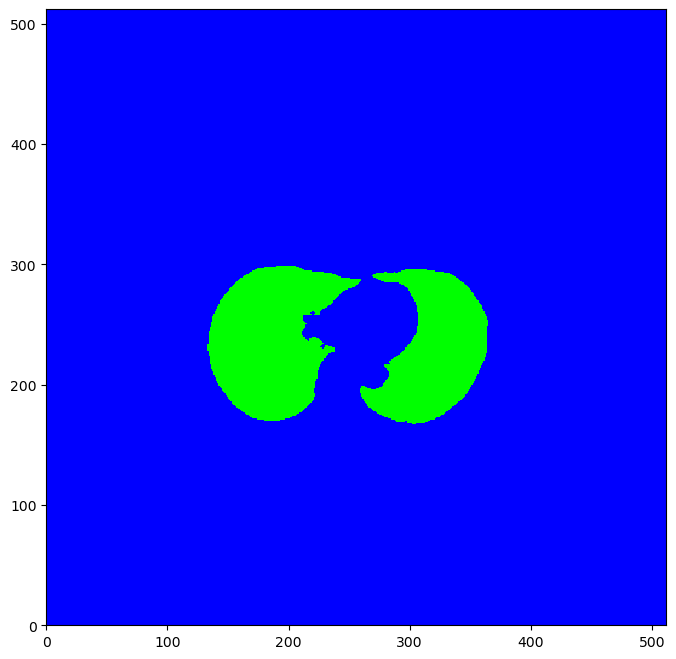

In [42]:
plt.figure(figsize=(8,8))
plt.pcolormesh(mask_new[170], cmap='brg')

Lets plot the full 3D image in plotly and create an interactive plot:

- First decrease the resolution a little bit:

In [43]:
im = zoom(1*(mask_new), (0.4,0.4,0.4))

Get arrays of 
x , 
y , and 
z . In a CT scan, the difference between pixels in the z direction is about 4 times bigger than in the 
 and 
 directions:

In [44]:
z, y, x = [np.arange(i) for i in im.shape]
z*=4

Create a meshgrid:

In [45]:
X,Y,Z = np.meshgrid(x,y,z, indexing='ij')

Create a 3D plotly plot



In [46]:
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=np.transpose(im,(1,2,0)).flatten(),
    isomin=0.1,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.write_html("test.html")

In [47]:
img_new = mask_new * img


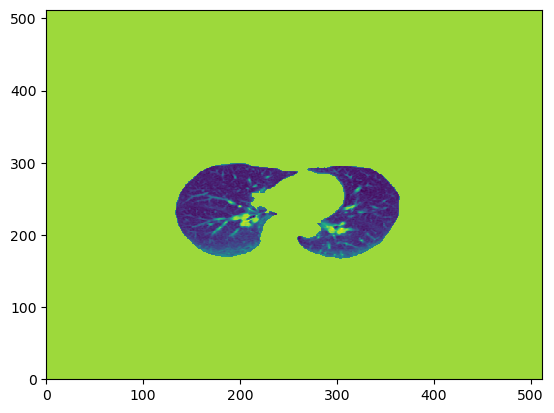

In [48]:
plt.pcolormesh(img_new[170])